In [13]:
from nepse import AsyncNepse 
import asyncio
import pandas as pd
from datetime import datetime, timedelta
import os
import glob

In [14]:
nepse = AsyncNepse()
nepse.setTLSVerification(False)  # Temporary, until NEPSE sorts its SSL certificate problem

In [15]:
df=pd.read_json(r'files\2025\2025-02-20.json')
# df['id']=df['marketDepth'][0].get('buyMarketDepthList')[0].get('stockId')
df

,timestamp,data
0,2025-02-20 11:00:40.062748,{'USHL': 'error code Expecting value: line 1 c...
1,2025-02-20 11:26:45.367487,"{'USHL': {'totalBuyQty': 3175, 'marketDepth': ..."
2,2025-02-20 11:58:02.104364,"{'USHL': {'totalBuyQty': 3794, 'marketDepth': ..."
3,2025-02-20 12:30:09.986182,"{'USHL': {'totalBuyQty': 6152, 'marketDepth': ..."
4,2025-02-20 13:04:19.277013,"{'USHL': {'totalBuyQty': 6317, 'marketDepth': ..."
5,2025-02-20 13:26:29.873518,"{'USHL': {'totalBuyQty': 6197, 'marketDepth': ..."
6,2025-02-20 14:04:56.426690,"{'USHL': {'totalBuyQty': 7184, 'marketDepth': ..."
7,2025-02-20 14:28:13.389816,"{'USHL': {'totalBuyQty': 5904, 'marketDepth': ..."
8,2025-02-20 14:40:23.767901,"{'USHL': {'totalBuyQty': 6087, 'marketDepth': ..."


In [17]:
df_combined = pd.DataFrame()
for i in df.index:
    df1 = pd.DataFrame.from_dict(df['data'][i]).T[['totalBuyQty', 'totalSellQty']]
    df1['timestamp'] = df['timestamp'][i]
    df1.reset_index(inplace=True)
    if df_combined.empty:
        df_combined = df1
    else:
        df_combined = pd.concat([df_combined, df1])

In [18]:
df_combined=pd.merge(df_combined, pd.DataFrame.from_dict(await nepse.getCompanyList())[['symbol', 'sectorName']], left_on='index',right_on='symbol', how='left')

In [19]:
df_combined.to_clipboard(index=False)

In [8]:
pos=7
script="MSHL"

dict=df.iloc[pos]['data'][script]
df1=pd.DataFrame.from_dict(dict["marketDepth"]["buyMarketDepthList"])
print(df1)

df2=pd.DataFrame.from_dict(dict["marketDepth"]["sellMarketDepthList"])
print(df2)

pd.DataFrame.from_dict(dict)


   stockId  orderBookOrderPrice  quantity  orderCount  isBuy   buy   sell
0     9215               1031.5       430           1      1  True  False
1     9215               1031.1       500           1      1  True  False
2     9215               1031.0       500           1      1  True  False
3     9215               1027.0      1500           2      1  True  False
4     9215               1025.1       200           1      1  True  False
   stockId  orderBookOrderPrice  quantity  orderCount  isBuy    buy  sell
0     9215               1040.0        20           2      2  False  True
1     9215               1044.0        60           2      2  False  True
2     9215               1045.0       100           1      2  False  True
3     9215               1049.0        10           1      2  False  True
4     9215               1049.9       100           1      2  False  True


,totalBuyQty,marketDepth,totalSellQty
buyMarketDepthList,126762,"[{'stockId': 9215, 'orderBookOrderPrice': 1031...",7232
sellMarketDepthList,126762,"[{'stockId': 9215, 'orderBookOrderPrice': 1040...",7232


In [3]:

# Initialize an empty DataFrame
df_combined = pd.DataFrame()

# Loop through each JSON file in the directory
for file in glob.glob(r'files\2025\*.json'):
    df_temp = pd.read_json(file)
    for i in range(len(df_temp['data'])):
        df1 = pd.DataFrame.from_dict(df_temp['data'][i]).T[['totalBuyQty', 'totalSellQty']]
        df1['timestamp'] = df_temp['timestamp'][i]
        df1.reset_index(inplace=True)
        if df_combined.empty:
            df_combined = df1
        else:
            df_combined = pd.concat([df_combined, df1])

# Assign the combined DataFrame to df2
df3 = df_combined

<Axes: xlabel='timestamp'>

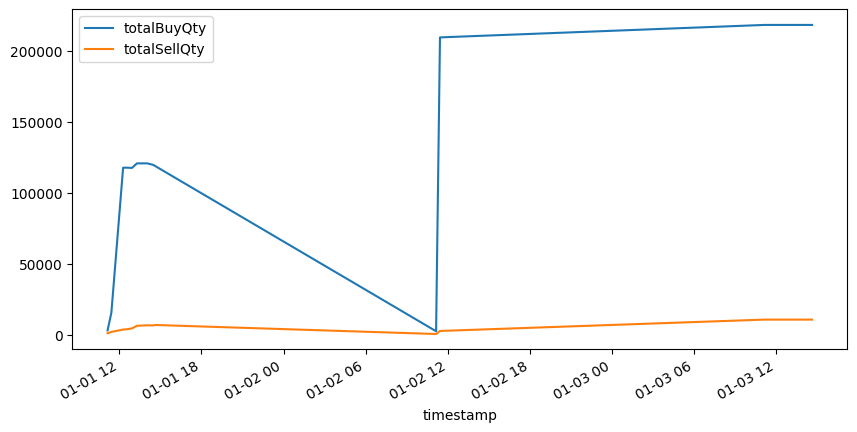

In [60]:
df3[df3['index']=='SNLI'].plot(x='timestamp', y=['totalBuyQty', 'totalSellQty'], figsize=(10, 5))

In [27]:
for i in range(len(df['data'])):
    df1=pd.DataFrame.from_dict(df['data'][i]).T[['totalBuyQty','totalSellQty']]
    df1['timestamp']=df['timestamp'][i]
    df1.reset_index(inplace=True)
    if i==0:
        df2=df1
    else:
        df2=pd.concat([df2,df1])

In [37]:
df2[df2['index']=='UPCL']

,index,totalBuyQty,totalSellQty,timestamp
466,UPCL,8210,700,2025-01-01 11:08:38.469359
466,UPCL,26211,1160,2025-01-01 11:25:13.886984
466,UPCL,39489,8230,2025-01-01 12:16:44.498276
466,UPCL,41212,8765,2025-01-01 12:31:21.399839
466,UPCL,45140,11354,2025-01-01 12:55:36.500189
466,UPCL,45673,12282,2025-01-01 13:17:21.609275
466,UPCL,46773,17285,2025-01-01 14:02:49.728837
466,UPCL,49913,14801,2025-01-01 14:29:05.596801
466,UPCL,49262,15555,2025-01-01 14:37:13.072795


In [42]:
def get_ohlc_data(df, script,qty_type):
    # Filter the dataframe for the given script
    script_data = df[df['index'] == script]

    # Ensure the data is sorted by timestamp
    script_data = script_data.sort_values(by='timestamp')

    # Get the OHLC data
    ohlc_data = {
        'open': script_data.iloc[0][qty_type],
        'high': script_data[qty_type].max(),
        'low': script_data[qty_type].min(),
        'close': script_data.iloc[-1][qty_type]
    }
    return ohlc_data

# Example usage
ohlc_data = get_ohlc_data(df2, 'UPCL','totalSellQty')
print(ohlc_data)

{'open': 700, 'high': 17285, 'low': 700, 'close': 15555}


<Axes: xlabel='timestamp'>

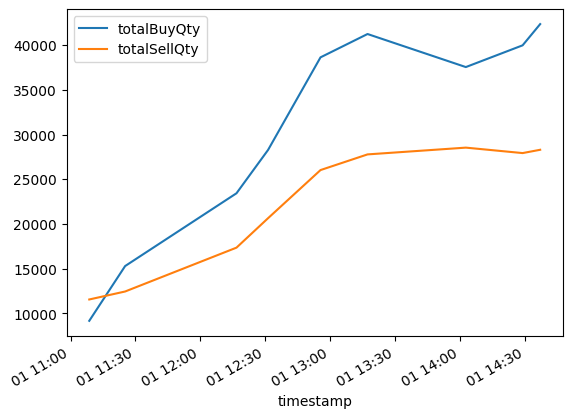

In [43]:
df2[df2['index']=='SHIVM'].plot(x='timestamp',y=['totalBuyQty','totalSellQty'])

In [22]:
df2[df2['symbol']=='SMHL']

KeyError: 'symbol'

In [21]:

pd.DataFrame.from_dict(await nepse.getCompanyList()).to_clipboard()

In [20]:
await nepse.getMarketStatus()

{'isOpen': 'CLOSE', 'asOf': '2024-12-26T15:00:00', 'id': 80}

In [9]:
pd.DataFrame.from_dict(df['data'][0])

ValueError: If using all scalar values, you must pass an index

In [3]:
datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

'2024-12-26_18-52-50'

In [6]:
from datetime import timedelta

adjusted_time = datetime.now() - timedelta(hours=5, minutes=45)
adjusted_time.strftime("%Y-%m-%d_%H-%M-%S")

'2024-12-26_13-39-34'

In [21]:
def get_id(dep_dict):
    if isinstance(dep_dict, dict) and 'buyMarketDepthList' in dep_dict:
        try:
            return dep_dict.get('buyMarketDepthList')[0].get('stockId')
        except (IndexError, AttributeError):
            return None  # Return None if the structure isn't as expected
    return None  # Return None for non-dictionaries or invalid inputs

In [38]:
pd.DataFrame.from_dict(await nepse.getCompanyList()).to_clipboard()

In [ ]:
adjusted_time = datetime.now() - pd.Timedelta(hours=5, minutes=45)
adjusted_time.strftime("%Y-%m-%d_%H-%M-%S")

In [2]:
nepse = AsyncNepse()
nepse.setTLSVerification(False)  # Temporary, until NEPSE sorts its SSL certificate problem

async def fetch_company_details():
    # Fetch the list of companies
    company_list = await nepse.getCompanyList()

    # Fetch details for each company concurrently
    tasks = [
        nepse.getCompanyDetails(company['symbol']) 
        for company in company_list 
        if company['status'] == 'A'
    ]

    company_details = await asyncio.gather(*tasks)

    # Combine company and details
    result = []
    for company, details in zip(company_list, company_details):
        # If details is a list, handle it appropriately
        if isinstance(details, list):
            # Add details as a key-value pair
            result.append({**company, "details": details})
        elif isinstance(details, dict):
            # Merge dictionaries directly
            result.append({**company, **details})
        else:
            # Handle unexpected formats (optional)
            result.append({**company, "details": str(details)})

    return result

In [28]:
df=pd.DataFrame.from_dict(await nepse.getSecurityList())

NameError: name 'nepse' is not defined

In [5]:
async def main():
    results = await fetch_company_details()

    # Ensure the "files/" directory exists
    os.makedirs("files", exist_ok=True)

    # Generate filename with timestamp
    now = datetime.now()
    filename = now.strftime("%Y-%m-%d_%H-%M-%S")
    pd.DataFrame.from_dict(results).to_excel(f"files/{filename}.xlsx", index=False)

# Execute the main function
# asyncio.run(main()) ## This is not working in Jupyter Notebook, but in py file it must be the function
await main()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py:106: RuntimeWarning: coroutine 'main' was never awaited
  if proto not in {0, socket.IPPROTO_TCP, socket.IPPROTO_UDP} or \


In [105]:
# import plotly.graph_objects as go
# fig = go.Figure(data=go.Candlestick(x=demand_ohlc.reset_index()['a'],
#                     open=demand_ohlc['open'],
#                     high=demand_ohlc['high'],
#                     low=demand_ohlc['low'],
#                     close=demand_ohlc['close']))
# fig.show()